In [1]:
import numpy
import pandas

import matplotlib.pyplot
import seaborn

import sklearn

from itertools import cycle
import json
import os

%matplotlib inline

seaborn.set_context('poster')
seaborn.set_style('darkgrid')

current_palette = cycle(seaborn.color_palette())

In [2]:
print('  numpy version: {}'.format(numpy.__version__))
print(' pandas version: {}'.format(pandas.__version__))
print('seaborn version: {}'.format(seaborn.__version__))
print('   json version: {}'.format(json.__version__))
print('sklearn version: {}'.format(sklearn.__version__))

  numpy version: 1.15.3
 pandas version: 0.23.4
seaborn version: 0.9.0
   json version: 2.0.9
sklearn version: 0.20.0


In [3]:
from visualise_data import SequenceVisualisation

plotter = SequenceVisualisation('./', './train/00001')
sequence_window = (plotter.meta['start'], plotter.meta['end'])

# We can extract the time range of the activity 'jump' with the 'times_of_activity' function. 
# This function returns all of the times that jump was annotated, and it is indexed first 
# by the annotator, and then by the time at which it occurred. 
times_of_jump = plotter.times_of_activity('a_jump')

# You can get the times at which these. 
for ai, annotator_jumps in enumerate(times_of_jump): 
    print ('Annotator {}'.format(ai))
    
    # The annotator_jumps is a list of tuples. The length of this list specifies the number of segments as
    # annotated as 'a_jump' by this annotator. Each element of this list is a tuple that holds the start and 
    # end time of the t-th annotation in that order, ie: 
    for ti, (start, end) in enumerate(annotator_jumps, start=1): 
        print ('  Annotation {}'.format(ti))
        print ('    Start time: {}'.format(start))
        print ('    End time:   {}'.format(end))
        print ('    Duration:   {}'.format(end - start))
        print ()

# The sequence object also holds metadata regarding the length of the sequence. 
sequence_window = (plotter.meta['start'], plotter.meta['end'])
print (sequence_window)

Annotator 0
  Annotation 1
    Start time: 1775.6870000000001
    End time:   1776.348
    Duration:   0.6609999999998308

  Annotation 2
    Start time: 1776.901
    End time:   1777.87
    Duration:   0.9689999999998236

Annotator 1
  Annotation 1
    Start time: 1774.974
    End time:   1778.844
    Duration:   3.8700000000001182

(0, 1823.9170000000001)


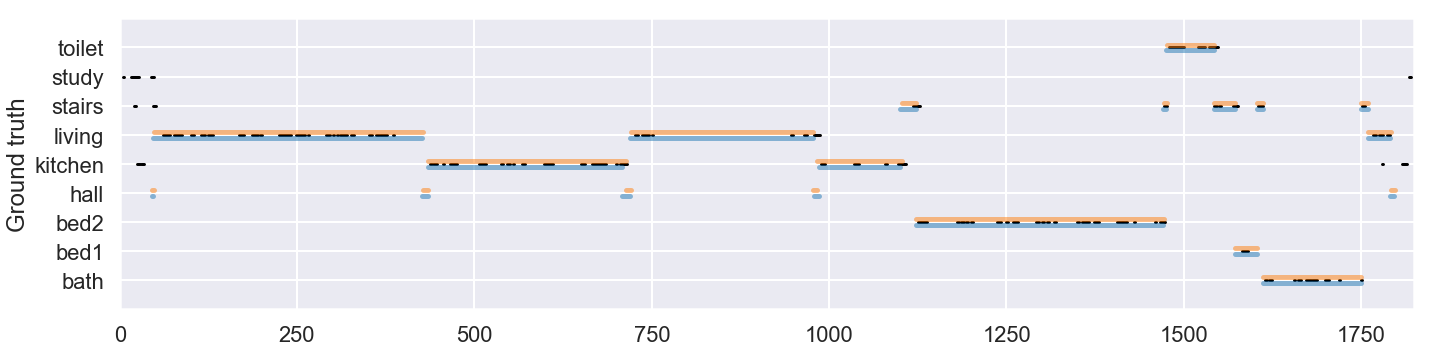

In [4]:
plotter.plot_pir(sequence_window, sharey=True)

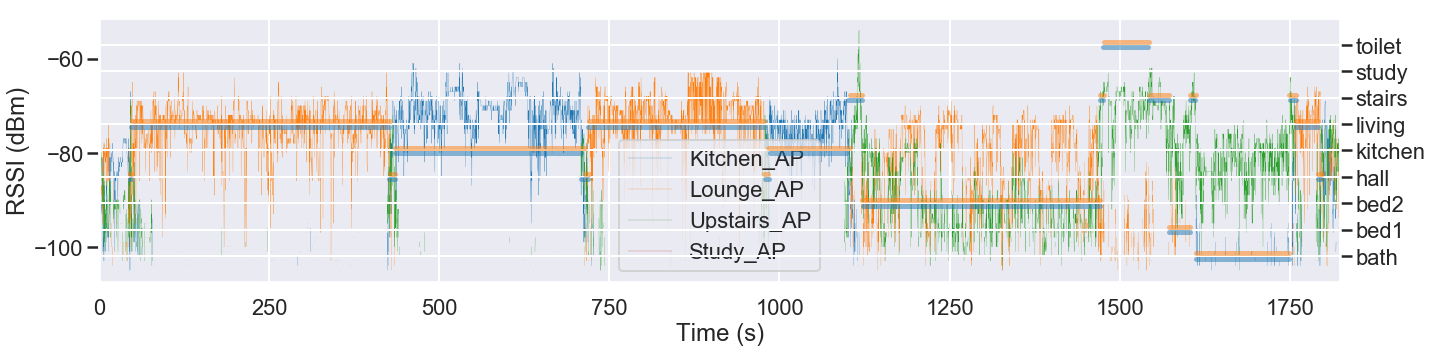

In [5]:
plotter.plot_rssi(sequence_window)

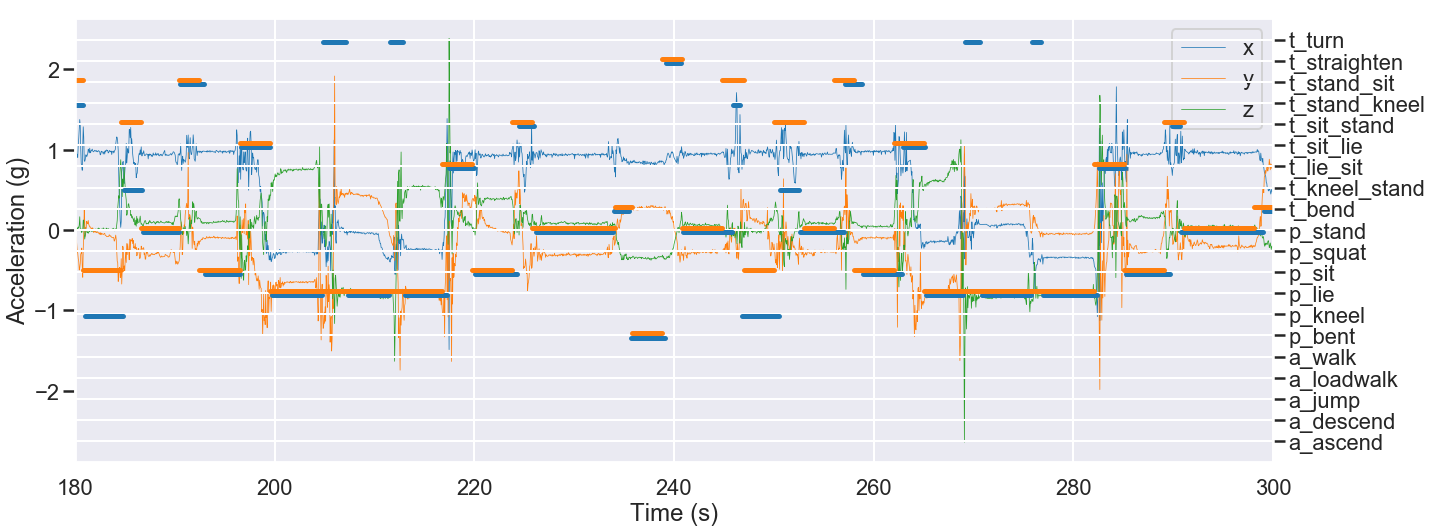

In [6]:
plotter.plot_acceleration((sequence_window[0] + 180, sequence_window[0] + 300))

Text(0.5, 0.98, '3D bounding box')

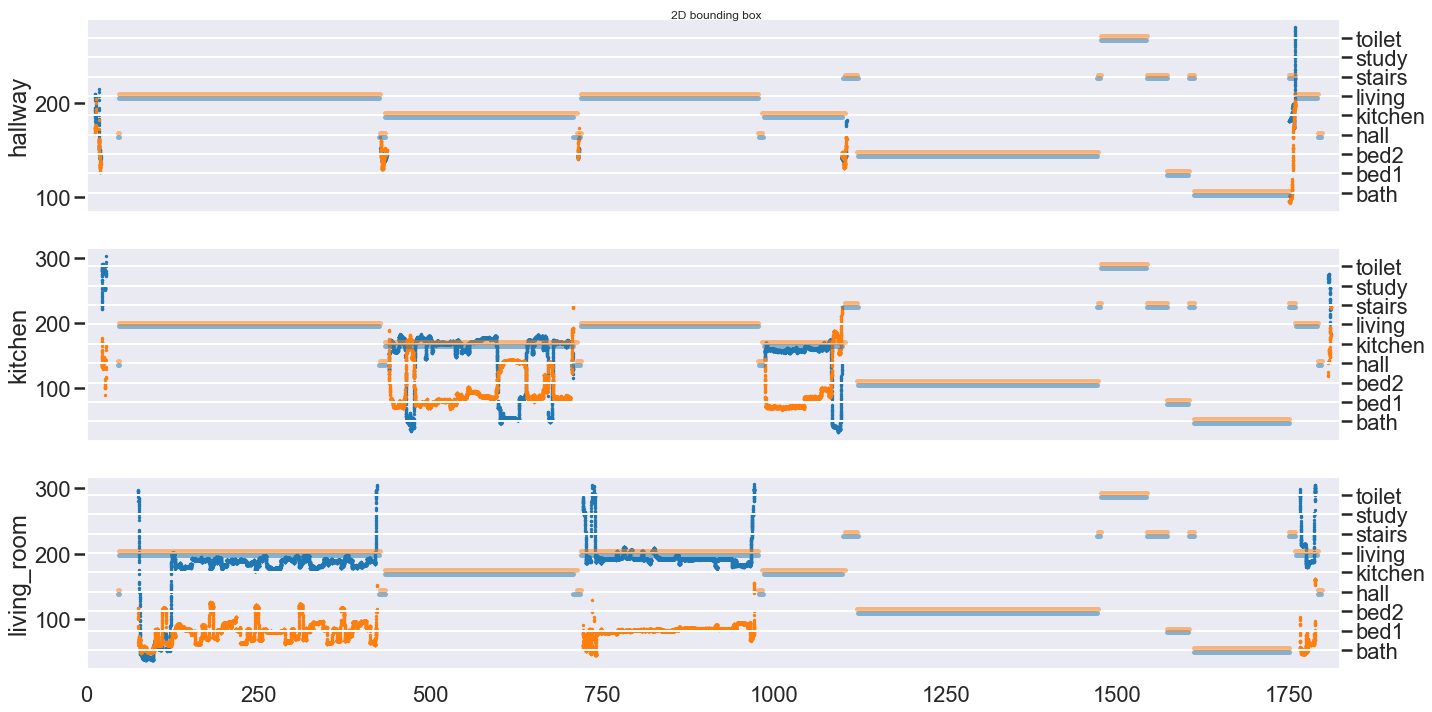

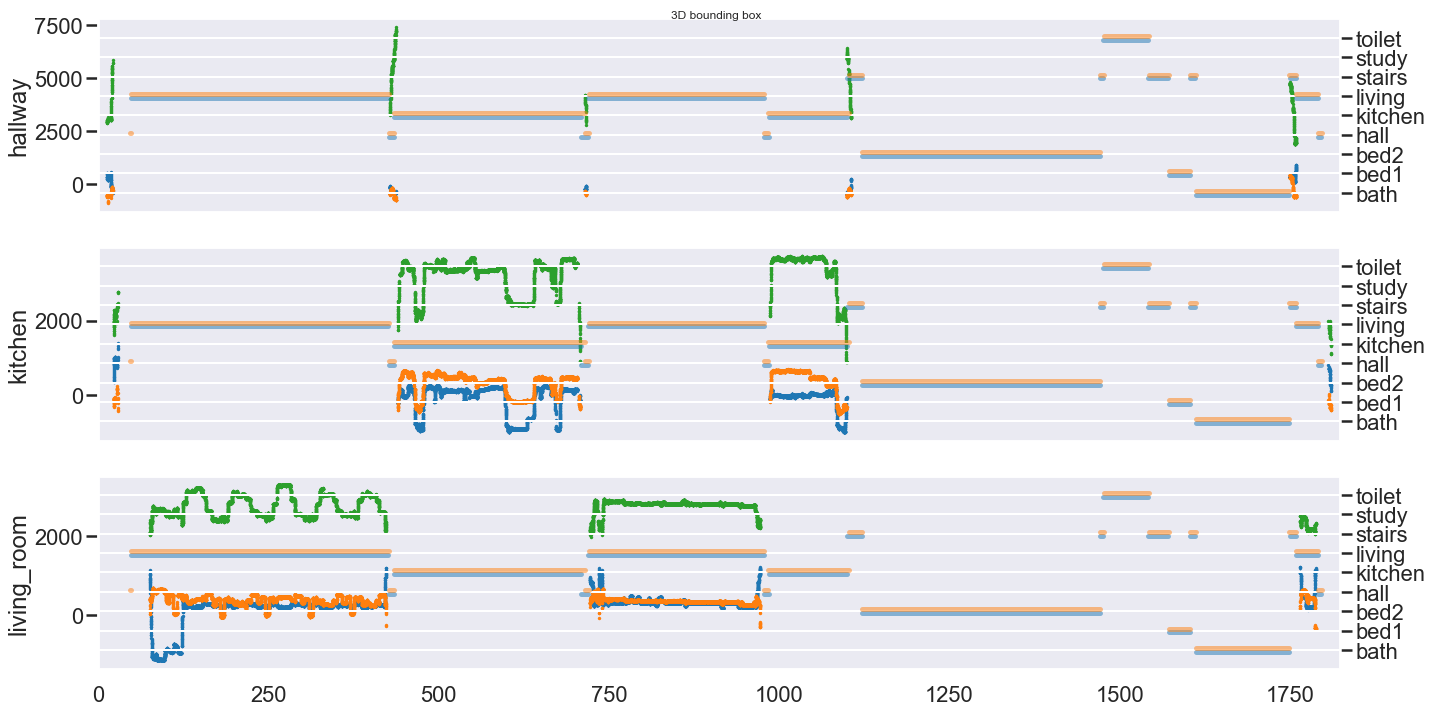

In [7]:
plotter.plot_video(plotter.centre_2d, sequence_window)
matplotlib.pyplot.gcf().suptitle('2D bounding box')

plotter.plot_video(plotter.centre_3d, sequence_window)
matplotlib.pyplot.gcf().suptitle('3D bounding box')

C:\Users\SH\Anaconda3\envs\py36_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


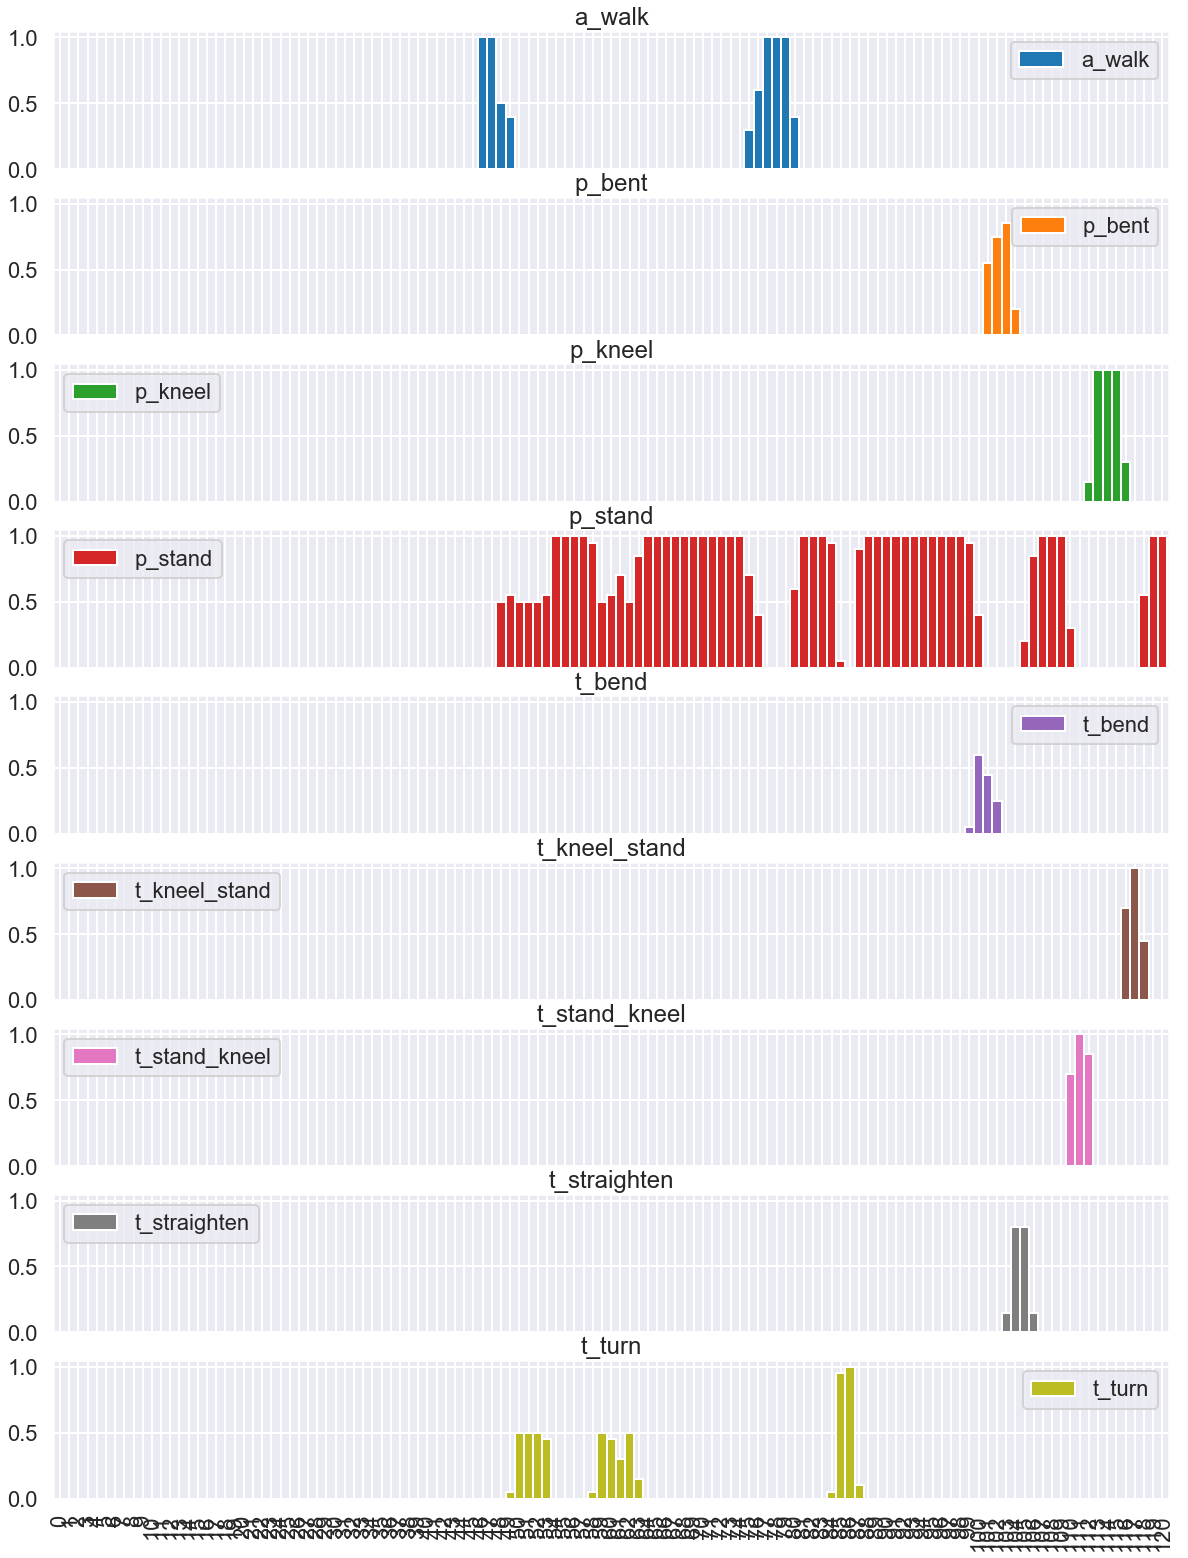

In [8]:
annotation_names = plotter.targets.columns.difference(['start', 'end'])

# Select only the first minute of data 
sub_df = plotter.targets.ix[:60 * 2]

# Select only the columns that are non-empty 
sub_df_cols = [col for col in annotation_names if sub_df[col].sum() > 0]

# Plot a bar-plot w
current_palette = cycle(seaborn.color_palette())
sub_df[sub_df_cols].plot(
    kind='bar', 
    subplots=True, 
    sharex=True, 
    sharey=True, 
    figsize=(20, 3 * len(sub_df_cols)), 
    width=1.0, 
    color=[next(current_palette) for _ in annotation_names]
);

In [9]:
from visualise_data import Sequence

import warnings
warnings.filterwarnings('ignore')

"""
For every data modality, we will extract some very simple features: the mean, min, max, median, and standard 
deviation of one second windows. We will put function pointers in a list called 'feature_functions' so that we 
can easily call these on our data for later
"""
feature_functions = [numpy.mean, numpy.std, numpy.min, numpy.median, numpy.max]
feature_names = ['mean', 'std', 'min', 'median', 'max']

# We will keep the number of extracted feature functions as a parameter 
num_ff = len(feature_functions)

# We will want to keep track of the feature names for later, so we will collect these in the following list: 
column_names = []

# These are the modalities that are available in the dataset, and the .iterate() function returns the data 
# in this order
modality_names = ['acceleration', 'rssi', 'pir', 'video_living_room', 'video_kitchen', 'video_hallway']

"""
Iterate over all training directories
"""
for train_test in ('train', 'test', ): 
#     if train_test is 'train': 
#         print ('Extracting features from training data.\n')
#      else: 
#         print ('\n\n\nExtracting features from testing data.\n')
        
    for fi, file_id in enumerate(os.listdir('./{}/'.format(train_test))):
        stub_name = str(file_id).zfill(5)

#         if train_test is 'train' or np.mod(fi, 50) == 0:
#             print ("Starting feature extraction for {}/{}".format(train_test, stub_name))

        # Use the sequence loader to load the data from the directory. 
        data = Sequence('./', './{}/{}'.format(train_test, stub_name))
        data.load()

        """
        Populate the column_name list here. This needs to only be done on the first iteration
        because the column names will be the same between datasets. 
        """
        if len(column_names) == 0:
            for lu, modalities in data.iterate():
                for modality, modality_name in zip(modalities, modality_names):
                    for column_name, column_data in modality.transpose().iterrows():
                        for feature_name in feature_names:
                            column_names.append('{0}_{1}_{2}'.format(modality_name, column_name, feature_name))

                # Break here 
                break 

        """
        Here, we will extract some features from the data. We will use the Sequence.iterate function. 

        This function partitions the data into one-second dataframes for the full data sequence. The first element 
        (which we call lu) represents the lower and upper times of the sliding window, and the second is a list of
        dataframes, one for each modality. The dataframes may be empty (due to missing data), and feature extraction 
        has to be able to cope with this! 

        The list rows will store the features extracted for this dataset
        """
        rows = []

        for ri, (lu, modalities) in enumerate(data.iterate()):
            row = []

            """
            Iterate over the sensing modalities. The order is given in modality_names. 

            Note: If you want to treat each modality differently, you can do the following: 

            for ri, (lu, (accel, rssi, pir, vid_lr, vid_k, vid_h)) in enumerate(data.iterate()):
                row.extend(extract_accel(accel))
                row.extend(extract_rssi(rssi))
                row.extend(extract_pir(pir))
                row.extend(extract_video(vid_lr, vid_k, vid_h))

            where the extract_accel/extract_rssi/extract_pir/extract_video functions are designed by you. 
            In the case here, we extract the same features from each modality, but optimal performance will 
            probably be achieved by considering different features for each modality. 
            """

            for modality in modalities:
                """
                The accelerometer dataframe, for example, has three columns: x, y, and z. We want to extract features 
                from all of these, and so we iterate over the columns here. 
                """
                for name, column_data in modality.transpose().iterrows():
                    if len(column_data) > 3:
                        """
                        Extract the features stored in feature_functions on the column data if there is sufficient 
                        data in the dataframe. 
                        """
                        row.extend(map(lambda ff: ff(column_data), feature_functions))

                    else:
                        """
                        If no data is available, put nan placeholders to keep the column widths consistent
                        """
                        row.extend([numpy.nan] * num_ff)

            # Do a quick sanity check to ensure that the feature names and number of extracted features match
            assert len(row) == len(column_names)

            # Append the row to the full set of features
            rows.append(row)

            # Report progress 
#             if train_test is 'train':
#                 if np.mod(ri + 1, 50) == 0:
#                     print ("{:5}".format(str(ri + 1))),

#                 if np.mod(ri + 1, 500) == 0:
#                     print

        """
        At this stage we have extracted a bunch of simple features from the data. In real implementation, 
        it would be advisable to look at more interesting features, eg

          * acceleration: link
          * environmental: link
          * video: link

        We will save these features to a new file called 'columns.csv' for use later. This file will be located 
        in the name of the training sequence. 
        """
        df = pandas.DataFrame(rows)
        df.columns = column_names
        df.to_csv('./{}/{}/columns.csv'.format(train_test, stub_name), index=False)

#         if train_test is 'train' or np.mod(fi, 50) == 0:
#             if train_test is 'train': print 
#             print ("Finished feature extraction for {}/{}\n".format(train_test, stub_name))

In [53]:
"""
We will define two convenience function to load the extracted features and their 
"""


def load_sequence(file_id):
    filename = str(file_id).zfill(5)

    df = pandas.read_csv('./train/{}/columns.csv'.format(filename))
    data = df.values
    target = numpy.asarray(pandas.read_csv('./train/{}/targets.csv'.format(filename)))[:, 2:]

    return data, target


def load_sequences(file_ids):
    x_es = []
    y_es = []

    for file_id in file_ids:
        data, target = load_sequence(file_id)

        x_es.append(data)
        y_es.append(target)

    return numpy.row_stack(x_es), numpy.row_stack(y_es)


# Load the training and testing data 
train_x, train_y = load_sequences([1,2,3,4,5,6,7,8])
test_x, test_y = load_sequences([9])

print ("Check whether the train/test features are all finite (before imputation)")
print ('All training data finite:', numpy.all(numpy.isfinite(train_x)))
print ('All testing data finite:', numpy.all(numpy.isfinite(test_x)))
print 

# We will want to impute the missing data 
from sklearn.preprocessing import Imputer
imputer = Imputer()
imputer.fit(train_x)

train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

print ("Check whether the train/test features are all finite (after imputation)")
print ('All training data finite:', numpy.all(numpy.isfinite(train_x)))
print ('All testing data finite:', numpy.all(numpy.isfinite(test_x)))
print 

# Load the label names 
labels = json.load(open('./annotations.json'))
n_classes = len(labels)

"""
Note, not all data is annotated, so we select only the annotated rows
"""
train_y_has_annotation = numpy.isfinite(train_y.sum(1))
train_x = train_x[train_y_has_annotation]
train_y = train_y[train_y_has_annotation]

test_y_has_annotation = numpy.isfinite(test_y.sum(1))
test_x = test_x[test_y_has_annotation]
test_y = test_y[test_y_has_annotation]


"""
Print simple statistics regarding the number of instances
"""
print ("Training data shapes:")
print ("train_x.shape: {}".format(train_x.shape))
print ("train_y.shape: {}".format(train_y.shape))
print 

print ("Testing data shapes")
print ("test_x.shape: {}".format(test_x.shape))
print ("test_y.shape: {}".format(test_y.shape))
print

Check whether the train/test features are all finite (before imputation)
All training data finite: False
All testing data finite: False
Check whether the train/test features are all finite (after imputation)
All training data finite: True
All testing data finite: True
Training data shapes:
train_x.shape: (12513, 305)
train_y.shape: (12513, 20)
Testing data shapes
test_x.shape: (1824, 305)
test_y.shape: (1824, 20)


<function print>

,Class Weight,Prior Class Distribution
Activity,,
a_ascend,1.352985,0.007622
a_descend,1.386846,0.006826
a_jump,1.595874,0.002657
a_loadwalk,1.353187,0.007617
a_walk,0.347784,0.101911
p_bent,0.661082,0.041766
p_kneel,1.047236,0.017147
p_lie,0.398865,0.085658
p_sit,0.207586,0.187622


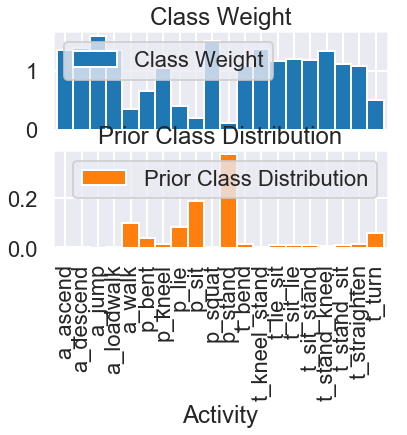

In [54]:
activity_names = json.load(open('./annotations.json', 'r'))
class_weights = numpy.asarray(json.load(open('./class_weights.json', 'r')))

class_prior = train_y.mean(0)

df = pandas.DataFrame({
        'Activity': activity_names, 
        'Class Weight': class_weights,
        'Prior Class Distribution': class_prior
    })

df.set_index('Activity', inplace=True)
# reset colour palette
current_palette = cycle(seaborn.color_palette())
df.plot(
    kind='bar',
    width=1.0,
    subplots=True,
    color=[next(current_palette), next(current_palette)], 
)

df

In [55]:
se_cols = ['start', 'end']

num_lines = 0

with open('submission_prior_baseline.csv', 'w') as fil: 
    fil.write(','.join(['record_id'] + se_cols + annotation_names.tolist()))
    fil.write('\n')
            
    for te_ind_str in sorted(os.listdir(os.path.join('./', 'test'))):
        te_ind = int(te_ind_str)

        meta = json.load(open(os.path.join('./', 'test', te_ind_str, 'meta.json')))

        starts = range(meta['end'])
        ends = range(1, meta['end'] + 1)

        for start, end in zip(starts, ends):
            row = [te_ind, start, end] + class_prior.tolist()

            fil.write(','.join(map(str, row)))
            fil.write('\n')
            
            num_lines += 1
            
print ("{} lines written.".format(num_lines))

16689 lines written.


In [56]:
from sklearn.neighbors import NearestNeighbors

"""
Define a simple class that inherits from sklearn.neighbors.NearestNeighbors. 
We will adjust the fit/predict as necessary
"""
class ProbabilisticKNN(NearestNeighbors): 
    def __init__(self, n_neighbors): 
        super(ProbabilisticKNN, self).__init__(n_neighbors)
        
        self.train_y = None
        
    def fit(self, train_x, train_y): 
        """
        The fit function requires both train_x and train_y. 
        See 'The selected model' section above for explanation
        """
        
        self.train_y = numpy.copy(train_y)
        
        super(ProbabilisticKNN, self).fit(train_x)
        
    def predict_proba(self, test_x): 
        """
        This function finds the k closest instances to the unseen test data, and 
        averages the train_labels of the closest instances. 
        """
        
        # Find the nearest neighbours for the test set
        test_neighbours = self.kneighbors(test_x, return_distance=False)
        
        # Average the labels of these for prediction
        return numpy.asarray(
            [self.train_y[inds].mean(0) for inds in test_neighbours]
        )

# Learn the KNN model 
nn = ProbabilisticKNN(n_neighbors=11)
nn.fit(train_x, train_y)

# Predict on the test instances
test_predicted = nn.predict_proba(test_x)

In [57]:
def brier_score(given, predicted, weight_vector): 
    return numpy.power(given - predicted, 2.0).dot(weight_vector).mean()

knn_brier_score = brier_score(test_y, test_predicted, class_weights)

print ("Brier score on test set with the KNN model")
print (knn_brier_score)
print 

# For comparison to the KNN model, test the prior class distribution  
prior_matrix = numpy.repeat(class_prior.reshape((1, -1)), test_y.shape[0], axis=0)
prior_brier_score = brier_score(test_y, prior_matrix, class_weights)

print ("Brier score on test using the prior class probability as a constant model")
print (prior_brier_score)
print

Brier score on test set with the KNN model
0.2833002106457619
Brier score on test using the prior class probability as a constant model
0.3012346024929109


<function print>

In [58]:
brier_scores = []

k_range = numpy.power(2, range(8))
for k in k_range: 
    print ("Learning model for k={:3d}".format(k)), 
    
    nn = ProbabilisticKNN(n_neighbors=k)
    nn.fit(train_x, train_y)
    
    predicted = nn.predict_proba(test_x)
    
    brier_scores.append(brier_score(test_y, predicted, class_weights))
    
    print ("score={:.5f}".format(brier_scores[-1]))

Learning model for k=  1
score=0.46975
Learning model for k=  2
score=0.37864
Learning model for k=  4
score=0.33001
Learning model for k=  8
score=0.29298
Learning model for k= 16
score=0.27326
Learning model for k= 32
score=0.26209
Learning model for k= 64
score=0.25627
Learning model for k=128
score=0.25746


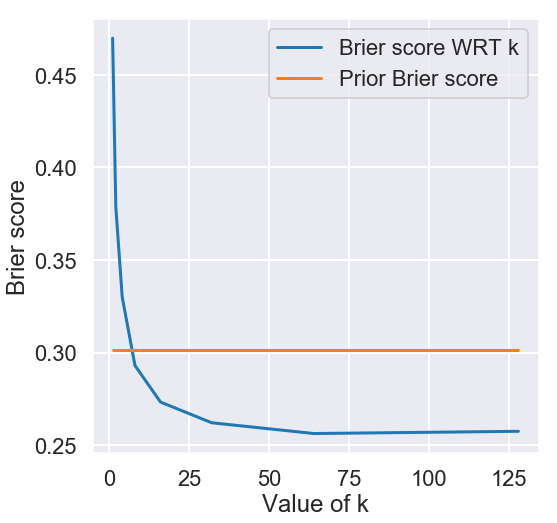

In [68]:
matplotlib.pyplot.figure(figsize=(8, 8))

matplotlib.pyplot.plot(k_range, brier_scores, label='Brier score WRT k')
matplotlib.pyplot.plot([k_range[0], k_range[-1]], [prior_brier_score, prior_brier_score], label='Prior Brier score')

matplotlib.pyplot.xlabel('Value of k') 
matplotlib.pyplot.ylabel('Brier score')

matplotlib.pyplot.legend(loc=0)

In [60]:
num_lines = 0

se_cols = ['start', 'end']

with open('submission_knn_baseline.csv', 'w') as fil: 
    fil.write(','.join(['record_id'] + se_cols + annotation_names.tolist()))
    fil.write('\n')
            
    for te_ind_str in sorted(os.listdir(os.path.join('./', 'test'))):        
        te_ind = int(te_ind_str)

        meta = json.load(open(os.path.join('./', 'test', te_ind_str, 'meta.json')))
        features = pandas.read_csv(os.path.join('./', 'test', te_ind_str, 'columns.csv')).values
        features = imputer.transform(features)
        
        probs = nn.predict_proba(features)
        
        starts = range(meta['end'])
        ends = range(1, meta['end'] + 1)

        for start, end, prob in zip(starts, ends, probs):
            row = [te_ind, start, end] + prob.tolist()

            fil.write(','.join(map(str, row)))
            fil.write('\n')
            
            num_lines += 1
            
print ("{} lines written.".format(num_lines))

16689 lines written.


Text(0.5, 1.0, 'Ground Truth')

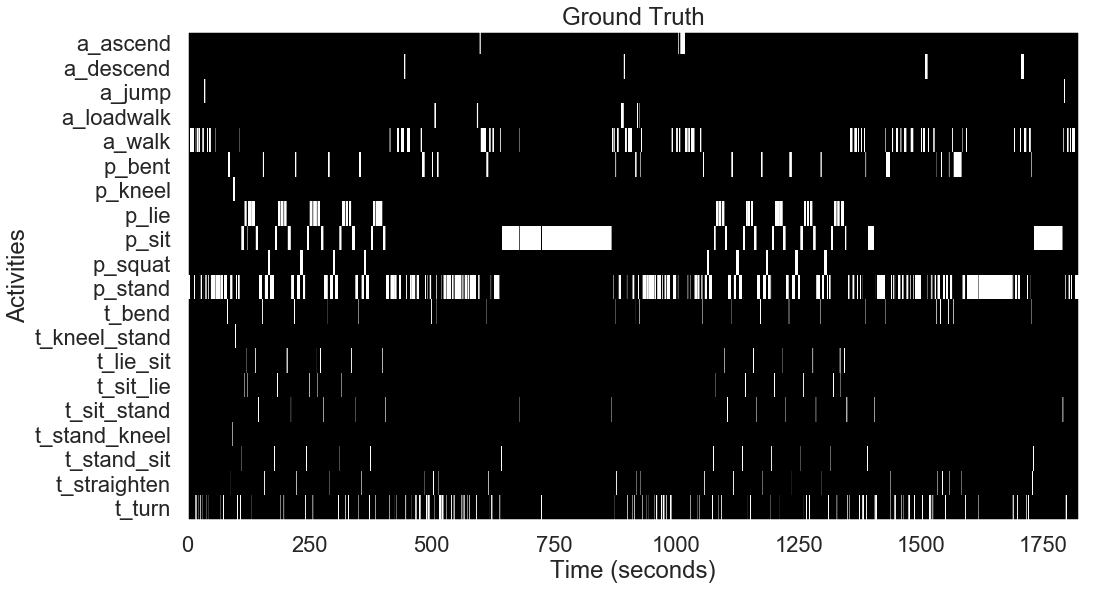

In [63]:
matplotlib.pyplot.figure(figsize=(16, 9))

matplotlib.pyplot.imshow(test_y.transpose(), interpolation='nearest', aspect='auto', cmap='gray')

matplotlib.pyplot.yticks(numpy.linspace(0,19,20), activity_names)

matplotlib.pyplot.grid('off')

matplotlib.pyplot.xlabel('Time (seconds)')
matplotlib.pyplot.ylabel('Activities')

matplotlib.pyplot.title('Ground Truth')

Text(0.5, 1.0, 'Ground Truth')

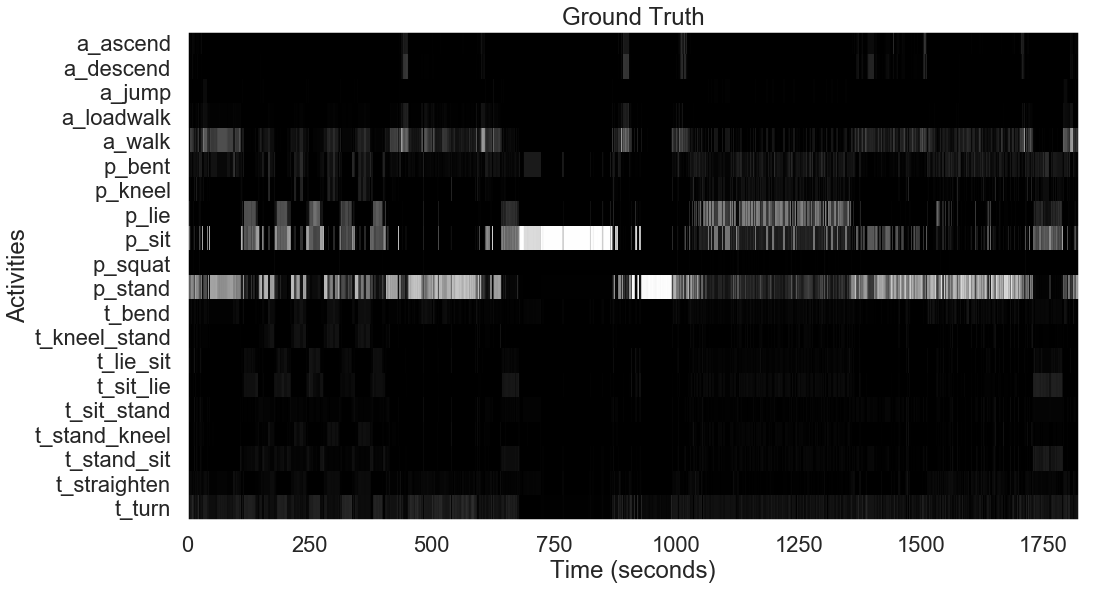

In [64]:
matplotlib.pyplot.figure(figsize=(16, 9))

matplotlib.pyplot.imshow(predicted.transpose(), interpolation='nearest', aspect='auto', cmap='gray')

matplotlib.pyplot.yticks(numpy.linspace(0,19,20), activity_names)

matplotlib.pyplot.grid('off')

matplotlib.pyplot.xlabel('Time (seconds)')
matplotlib.pyplot.ylabel('Activities')

matplotlib.pyplot.title('Ground Truth')